# Change detection in water indices

PAIRS allows to execute arbitrary math operations on data layers via *user defined functions* (UDFs). In this notebook we will use this feature to calculate moisture and water indices from Sentinel 2 data.

The general idea behind these indices is that water reflects less radiation in the infrared range than other land cover. While it is hard to extract moisture content -- or even just the presence of water bodies -- from raw satellite data (whether in the visible part of the optical spectrum or not), these indices allow to obtain such information much more clearly.

## Examples of water indices

There are a number of different water indices. See the following references for additional information see e.g.
- https://en.wikipedia.org/wiki/Normalized_difference_water_index
- McFeeters, S.K. The use of the Normalized Difference Water Index (NDWI) in the delineation of open water
features. Int. J. Remote Sens. 1996, 17, 1425–1432.
- Xu, H. Modification of normalised difference water index (NDWI) to enhance open water features in remotely
sensed imagery. Int. J. Remote Sens. 2006.
- Feyisa, G.L.; Meilby, H.; Fensholt, R.; Proud, S.R. Automated Water Extraction Index: A new technique for
surface water mapping using Landsat imagery. Remote Sens. Environ. 2014, 140, 23–35. 

In the following we will calcuulate mNDWI, NDMI, AWEInsh and AWEIsh in a single query.

In [18]:
from datetime import datetime, timedelta
import os, re, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [19]:
EIS_API_KEY=''
EIS_CLIENT_ID=''
EIS_ORG_ID=''

p2_credentials  = client.get_client(api_key   = EIS_API_KEY,
                                    client_id = EIS_CLIENT_ID,
                                    org_id    = EIS_ORG_ID,
                                    legacy    = False
                                   )


2023-06-19 15:20:01 - paw - INFO - The client authentication method is assumed to be OAuth2.
2023-06-19 15:20:01 - paw - INFO - The string starts with geospatial, where it should start with saascore; correcting.
2023-06-19 15:20:01 - paw - INFO - Legacy Environment is False
2023-06-19 15:20:04 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/pairs-query


The following helps when converting `datetime` objects to strings in ISO 8601-compliant format.

In [20]:
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

## Calculating water indices

We calculate the water indices from Sentinel 2 data. Note that high resolution satellites such as Sentinel 2 (or Landsat 8) do not cover the whole globe on a daily basis -- as would be the case for e.g. MODIS. Instead, the satellites' revisit frequency is about 5 days. This also means that just because there's data for a certain location on, say October 10 2019, there's also data for a nearby location.

When working with a specific site, it's just best to do a point query to verfiy what timestamps are available in the area. Alternatively one can use a user defined function that selects available data for each pixel. See the tutorials at https://pairs.res.ibm.com/tutorial for details.

In this notebook, we keep things simple and use specific dates. Namely July 30 and September 13 2019. The location of interest is near Winnipeg, Canada.

For readability we define a set of dictionaries that we think of as raw PAIRS layers and derived PAIRS layers. The former are identified by the layers' IDs, the latter are expressions to be used in UDFs. The labels match those used in the `rawLayers` dictionary.

In [21]:
rawLayers = {
    'SWIR_1' : '49686',
    'SWIR_2' : '49687',
    'NIR' : '49361',
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680'
}
derivedLayers = {
    'mNDWI' : '($Green - $SWIR_1) / ($Green + $SWIR_1)',
    'NDMI' : '($NIR - $SWIR_1) / ($NIR + $SWIR_1)',
    'AWEInsh' : '4 * ($Green - $SWIR_1) - (0.25 * $NIR + 2.75 * $SWIR_2)',
    'AWEIsh' : '$Blue + 2.5 * $Green - 1.5 * ($NIR + $SWIR_1) - 0.25 * $SWIR_2'
}
dates = {
    '201907' : datetime(2019, 7, 30).strftime(iso8601),
    '201909' : datetime(2019, 9, 13).strftime(iso8601)
}

We thus define the actual query. Note the use of `"output" : False` for the raw layers. This instructs PAIRS not to return (or generate) GeoTiffs for those layers.

In [22]:
queryJson = {
    'layers' : [
        {
            'alias' : '{0}_{1}'.format(lKey, dKey), 'type' : 'raster', 'id' : rawLayers[lKey],
            'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'output' : False
        }
        for lKey in rawLayers for dKey in dates
    ] + [
        {
            'alias' : '{0}_{1}'.format(lKey, dKey),
            'expression' : re.sub(r'(\$[A-Za-z0-9_]*)', r'\1_{}'.format(dKey), derivedLayers[lKey])
        }
        for lKey in derivedLayers for dKey in dates
    ],
    "spatial" : {"type" : "square",  "coordinates" : ['49.71826', '-97.4177619', '49.8936545', '-97.0997129']},
    "temporal" : {"intervals" : [{
        "snapshot" : datetime(2018, 6, 24).strftime(iso8601),
    }]}
}

In [ ]:
queryObj = query.submit_check_status_and_download(queryJson)


2023-06-19 15:20:13 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2023-06-19 15:20:14 - paw - INFO - The query was successfully submitted with the id: 1687176000_08414312.
2023-06-19 15:20:14 - paw - INFO - The query 1687176000_08414312 has the status Initializing.
2023-06-19 15:20:45 - paw - INFO - The query 1687176000_08414312 has the status NoDataFound.
2023-06-19 15:20:45 - paw - ERROR - The query 1687176000_08414312 failed, error NoDataFound .


## Analyzing the water and moisture indices

Since we have defined useful aliases, it makes sense to relabel the `.metadata` structure generated by the `.create_layers()` call. We do so by defining our own `metadata` dictionary.

In [9]:
metadata = dict()
for k in query.metadata:
    metadata[query.metadata[k]['datalayerAlias']] = query.metadata[k]
    metadata[query.metadata[k]['datalayerAlias']]['label'] = k
print(metadata.keys())

dict_keys(['NDMI_201909', 'AWEIsh_201907', 'mNDWI_201909', 'mNDWI_201907', 'NDMI_201907', 'AWEIsh_201909', 'AWEInsh_201909', 'AWEInsh_201907'])


Plotting the water index, it's interesting to see how much easier it is to identify water bodies compared to raw satellite imagery.

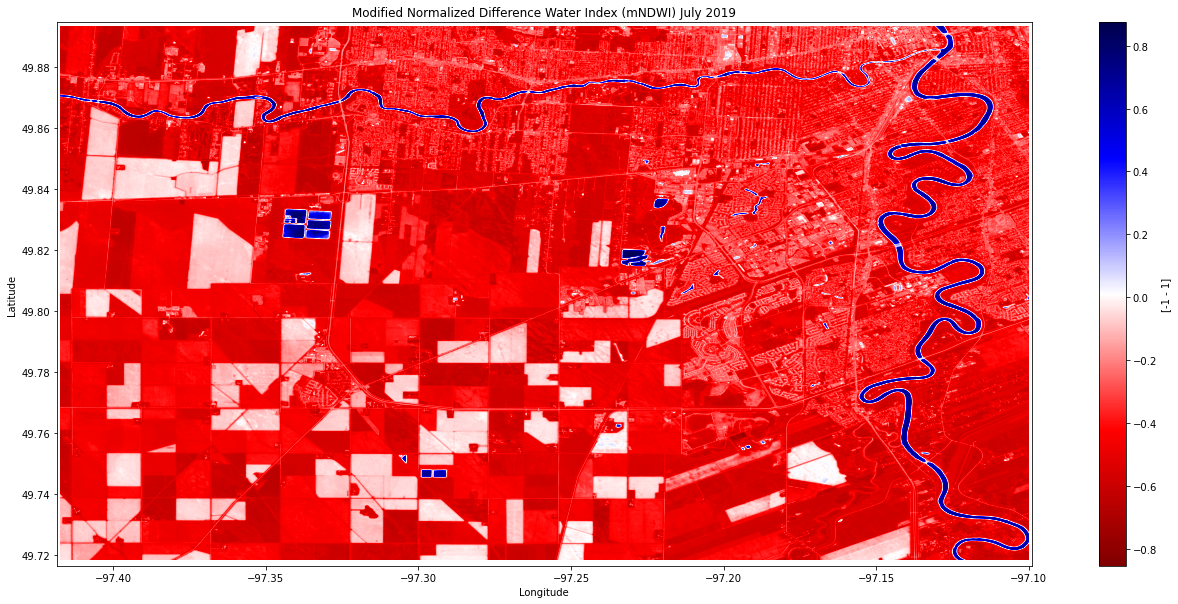

In [10]:
plt.figure(figsize = (24, 10))
plt.imshow(
    query.data[metadata['mNDWI_201907']['label']], cmap = 'seismic_r',
    extent = [metadata['mNDWI_201907']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']]
)
#plt.title('Heating degree days')
plt.colorbar(label = '[-1 - 1]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Modified Normalized Difference Water Index (mNDWI) July 2019')
plt.savefig('mNDWI_072019.png', dpi = 60, bbox_inches = 'tight', transparent = True)
plt.show()

It's instructive to compare the moisture index (NDMI) to the water index. Where the former essentially excludes fields, the latter shows them on equal footing with the rivers.

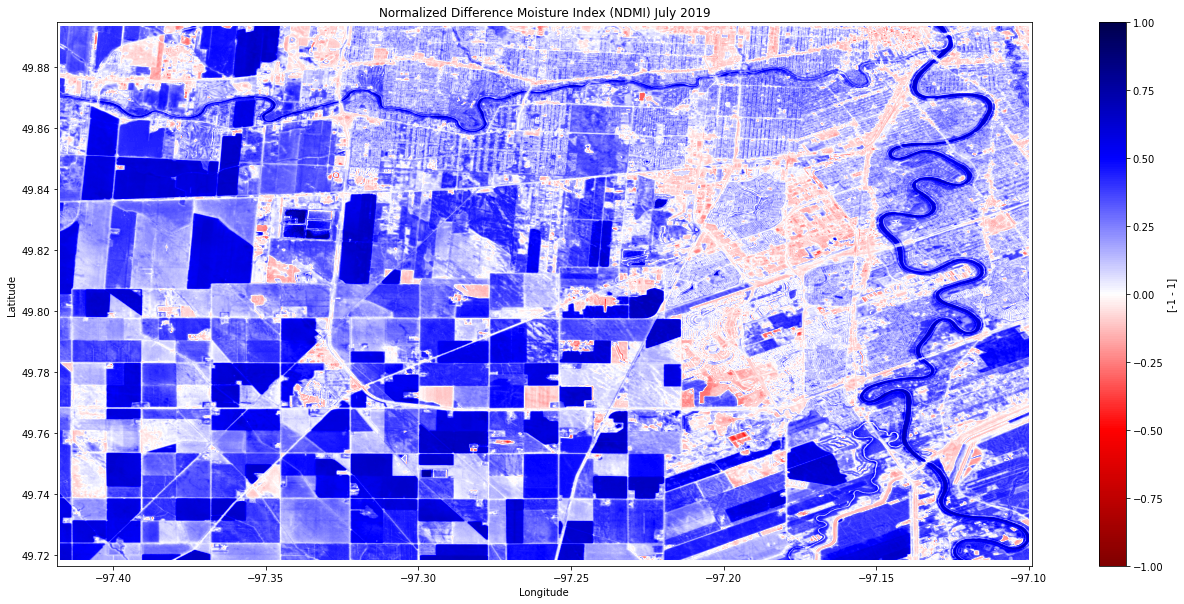

In [11]:
plt.figure(figsize = (24, 10))
plt.imshow(
    query.data[metadata['NDMI_201907']['label']], cmap = 'seismic_r',
    extent = [metadata['NDMI_201907']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']],
    vmin = -1, vmax = 1
)
#plt.title('Heating degree days')
plt.colorbar(label = '[-1 - 1]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Normalized Difference Moisture Index (NDMI) July 2019')
plt.savefig('NDMI_072019.png', dpi = 60, bbox_inches = 'tight', transparent = True)
plt.show()

A more interesting thing is to compare changes in the moisture index. Let's take a look what happened between July and September.

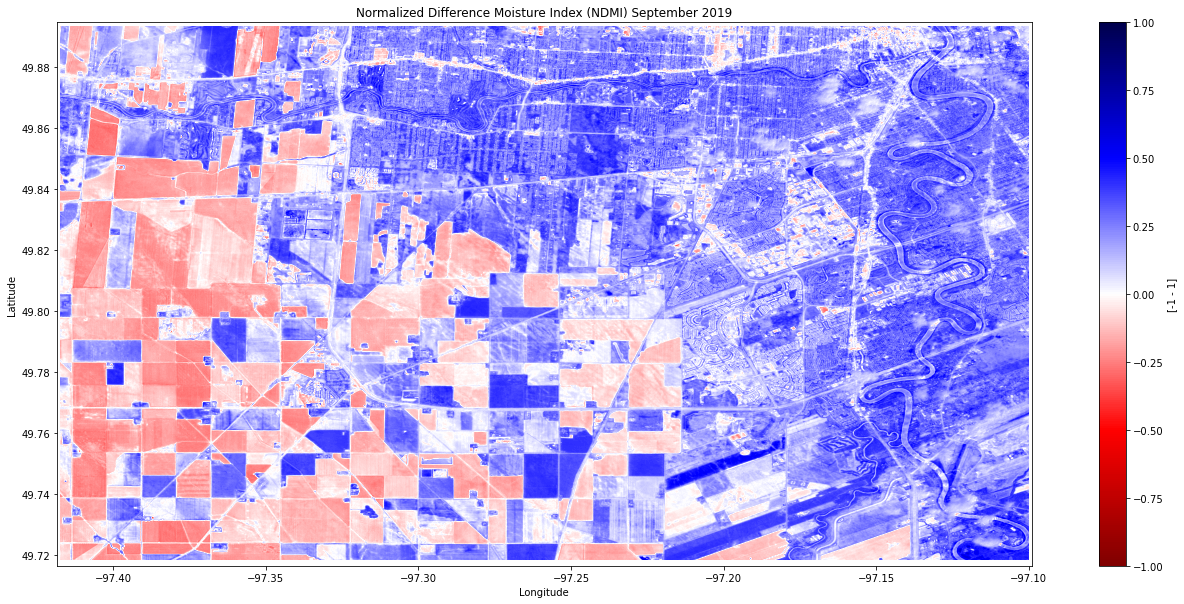

In [12]:
plt.figure(figsize = (24, 10))
plt.imshow(
    query.data[metadata['NDMI_201909']['label']], cmap = 'seismic_r',
    extent = [metadata['NDMI_201909']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']],
    vmin = -1, vmax = 1
)
#plt.title('Heating degree days')
plt.colorbar(label = '[-1 - 1]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Normalized Difference Moisture Index (NDMI) September 2019')
plt.savefig('NDMI_092019.png', dpi = 60, bbox_inches = 'tight', transparent = True)
plt.show()

Naturally, we can plot the differences directly.

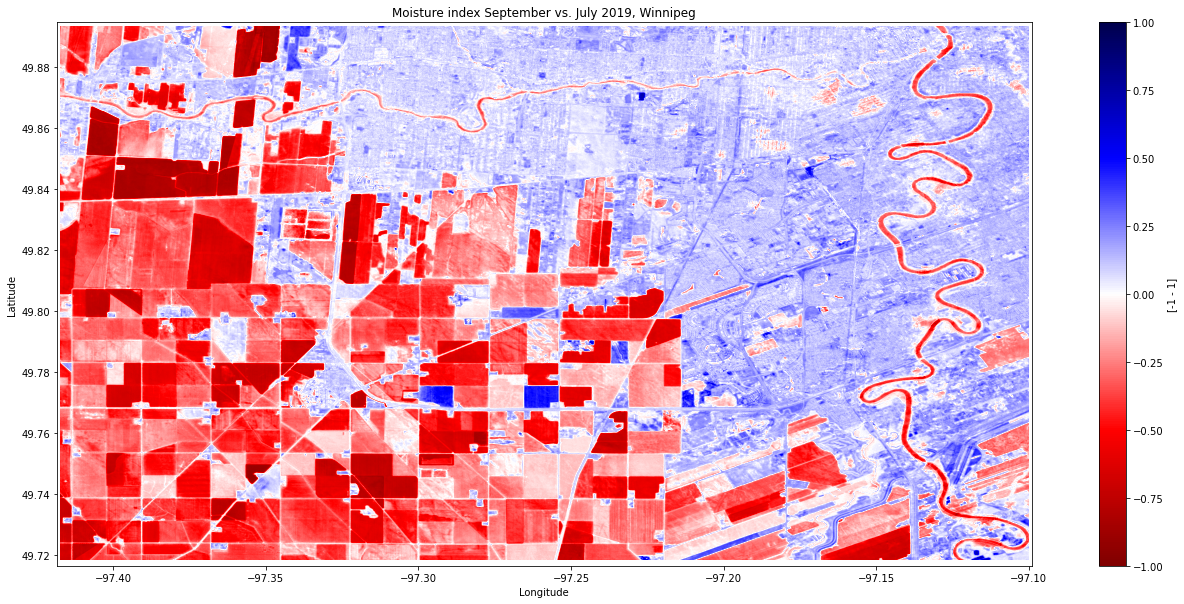

In [13]:
plt.figure(figsize = (24, 10))
plt.imshow(
    query.data[metadata['NDMI_201909']['label']] - query.data[metadata['NDMI_201907']['label']], cmap = 'seismic_r',
    extent = [metadata['NDMI_201909']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']],
    vmin = -1, vmax = 1
)
plt.title('Moisture index September vs. July 2019, Winnipeg')
plt.colorbar(label = '[-1 - 1]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('NDMI_Difference.png', dpi = 60, bbox_inches = 'tight', transparent = True)
plt.show()

Given the time of the year, it is reasonable to suspect a simple cause for the drop of moisture: harvest. To look deeper into this, we can calculate changes in the amounts of vegetation. For this, we use the Normalized Difference Vegetation Index (NDVI), a better known cousin of bouth NDMI and mNDWI.

## Differences in vegetation index

This time around, we calculate the difference in PAIRS instead of querying out the raw dates. It's a straightforward extension of our above example.

In [14]:
queryJson2 = {
    'layers' : [
        {
            'alias' : 'July',
            'type' : 'raster', 'id' : '49464', 'aggregation' : 'Max',
            'temporal' : {'intervals' : [{
                'start' : datetime(2019, 7, 1).strftime(iso8601), 'end' : datetime(2019, 8, 1).strftime(iso8601)
            }]},
            'output' : False
        },
        {
            'alias' : 'September',
            'type' : 'raster', 'id' : '49464', 'aggregation' : 'Max',
            'temporal' : {'intervals' : [{
                'start' : datetime(2019, 9, 1).strftime(iso8601), 'end' : datetime(2019, 10, 1).strftime(iso8601)
            }]},
            'output' : False
        },
        {
            'alias' : 'NDVIDifference', 'expression' : '$September - $July'
        }
    ],
    'spatial' : {'type' : 'square', 'coordinates' : ['49.71826', '-97.4177619', '49.8936545', '-97.0997129']},
    #'spatial' : {'type' : 'square', 'coordinates' : ['50.0237242', '-96.2168134', '50.1015786', '-96.1086822']},
    'temporal' : {'intervals' : [{
        'snapshot' : datetime(2019, 10, 1).strftime(iso8601)
    }]}
}

In [15]:
query2 = paw.PAIRSQuery(queryJson2, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key')
query2.submit()

In [16]:
query2.poll_till_finished()
query2.download()
query2.create_layers()

In [17]:
metadata2 = dict()
for k in query2.metadata:
    metadata2[query2.metadata[k]['datalayerAlias']] = query2.metadata[k]
    metadata2[query2.metadata[k]['datalayerAlias']]['label'] = k

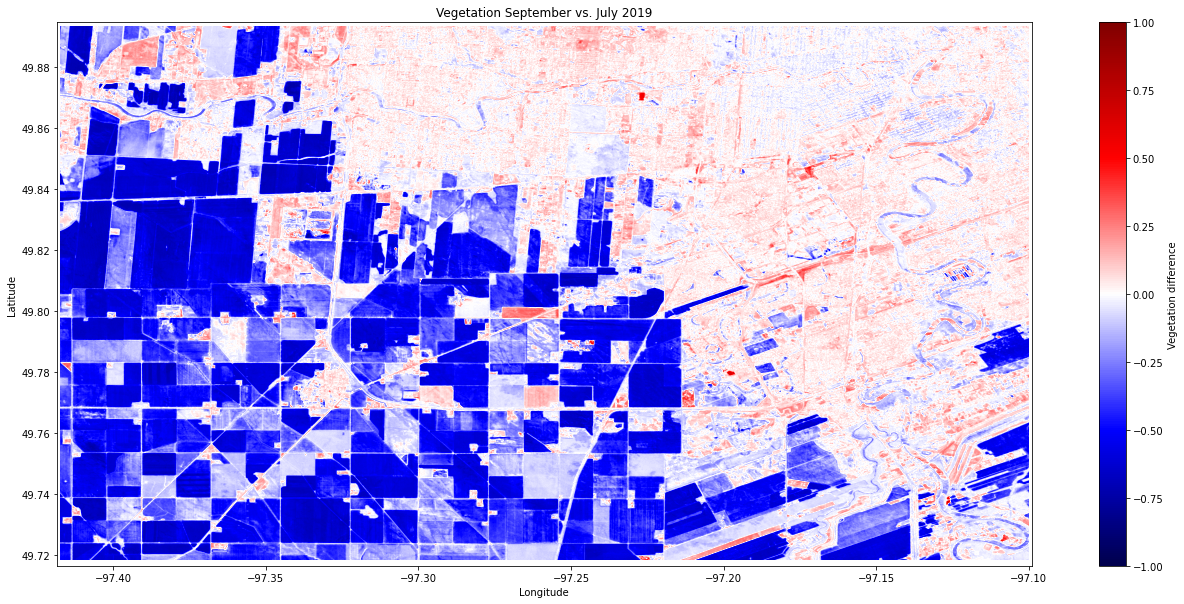

In [18]:
plt.figure(figsize = (24, 10))
plt.imshow(
    query2.data[metadata2['NDVIDifference']['label']], cmap = 'seismic', vmin = -1, vmax = 1,
    extent = [metadata2['NDVIDifference']['details']['boundingBox'][l] for l in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']]
)
plt.colorbar(label = 'Vegetation difference')
plt.title('Vegetation September vs. July 2019')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('vegetationDifferences_2019.png', dpi = 60, bbox_inches = 'tight', transparent = True)
plt.show()

As expected, we see a clear drop in vegetation in agricultural areas.